###  importing relevant libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:

from tabulate import tabulate
from numpy import array
from random import random
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB#57
from sklearn.naive_bayes import GaussianNB#52
from sklearn.naive_bayes import MultinomialNB#56
from sklearn.naive_bayes import CategoricalNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import csv
import math
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import time
%matplotlib inline


### Discovering Labels

In [3]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [4]:
def folder(f_name): #this function creates a folder.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("Tthe folder could not be created!")

In [5]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

In [6]:
altime=0
#def most_frequent(List): 
#    return max(set(List), key = List.count) 


 
def most_frequent(List):
    occurence_count = Counter(List)
    occurence_count={k: v for k, v in sorted(occurence_count.items(), key=lambda item: item[1],reverse=True)}
    big=list(occurence_count.values())
    big=big.count(big[0])
    return list(occurence_count.keys())[np.random.randint(big)]


def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
def create_exception(df): 
    exception_list=[]
    dominant_mac=[]
    for i in df['aggregated'].unique():
        k=df[df['aggregated']==i]
        for ii in ['MAC']:
            hist = {}
            for x in k[ii].values:
                hist[x] = hist.get(x, 0) + 1
            hist=dict(sorted(hist.items(), key=lambda item: item[1],reverse=True))
            temp=next(iter(hist))
            if temp not in dominant_mac:
                dominant_mac.append(temp)
            else:
                exception_list.append(temp)
    return exception_list




def merged(m_test,predict,step,mixed):
    second=time.time()
    mac_test=[]
    for q in m_test.index:
        mac_test.append(m_test[q])

    d_list=sorted(list(m_test.unique()))
    devices={}
    for q in d_list:
        devices[q]=[]    


    new_y=[0]*len(m_test)

    for q,qq in enumerate (mac_test):
        devices[qq].append(q)
    for q in devices:
        a = [devices[q][j:j + step] for j in range(0, len(devices[q]), step)]  
        for qq in a:
            step_list=[]
            for qqq in qq:
                step_list.append(predict[qqq])
            add=most_frequent(list(step_list))
            for qqq in qq:
                new_y[qqq]=add
    results=pd.DataFrame(m_test)
    results["aggregated"]=new_y
    results["normal"]=predict
    
    #MIXED METHOD
    if mixed:
        exception=create_exception(results)
        for q in exception:
            results.loc[results.MAC == q, 'aggregated'] = results['normal']

    return results["aggregated"].values,time.time()-second

## Calculation of evaluations

In [7]:
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ml):
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,i,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time,altime]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return line,class_based_results

In [8]:
def ML(loop1,loop2,output_csv1,cols,step,mixed,dname):

    #ths = open(output_csv, "w")
    #ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,Al-Time\n")
    

    from sklearn.metrics import balanced_accuracy_score
    from sklearn.preprocessing import Normalizer
    
    for ii in ml_list:
        #print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s'%
               #("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        output_csv=output_csv1.replace("ML",ii)
        repetition=10
        lines=[["Dataset","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T","Al-Time"]]
        for i in range(repetition):



            #TRAIN
            df = pd.read_csv(loop1,usecols=cols)
            m_train=df["MAC"]
            del df["MAC"]
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            #TEST
            df = pd.read_csv(loop2,usecols=cols)
            df = shuffle(df, random_state=42)
            m_test=df["MAC"]
            del df["MAC"]
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes




            results_y=[]
            cv+=1
            results_y.append(y_test)


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time=(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time=(float((time.time()-second)) )
            if step==1:
                altime=0
                line,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            else:
                predict,altime=merged(m_test,predict,step,mixed)
                line,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
                
                
            lines.append(line)
            df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)
            
        class_based_results=class_based_results/(repetition)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
  
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","CB.csv"))
        if True:
            cm=cm//repetition
            graph_name=output_csv+"_confusion matrix.pdf"   
            plt.figure(figsize = (40,28))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            #print("\n\n\n")             


            #plt.clf()

            
            
            
            
            



# Machine learning applications 

# Aalto Dataset

In [9]:
feature= ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy',
"MAC",
'Label']


In [10]:
ml_list={"DT" :DecisionTreeClassifier()}
dataset="./Aalto/"
folder(dataset)


    Dataset         T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/vs_1    0     1  DT    0.861    0.809   0.817  0.809  0.799  0.851      0    2.527     0.212          0
 1  results/vs_1    1     2  DT    0.86     0.809   0.818  0.809  0.799  0.851      0    2.532     0.24           0
 2  results/vs_1    2     3  DT    0.86     0.809   0.818  0.809  0.799  0.851      0    2.552     0.173          0
 3  results/vs_1    3     4  DT    0.861    0.809   0.818  0.809  0.799  0.851      0    2.897     0.195          0
 4  results/vs_1    4     5  DT    0.86     0.809   0.817  0.809  0.799  0.851      0    2.672     0.209          0
 5  results/vs_1    5     6  DT    0.86     0.808   0.817  0.808  0.798  0.851      0    1.903     0.142          0
 6  results/vs_1    6     7  DT    0.861    0.808   0.818  0.808  0.798 

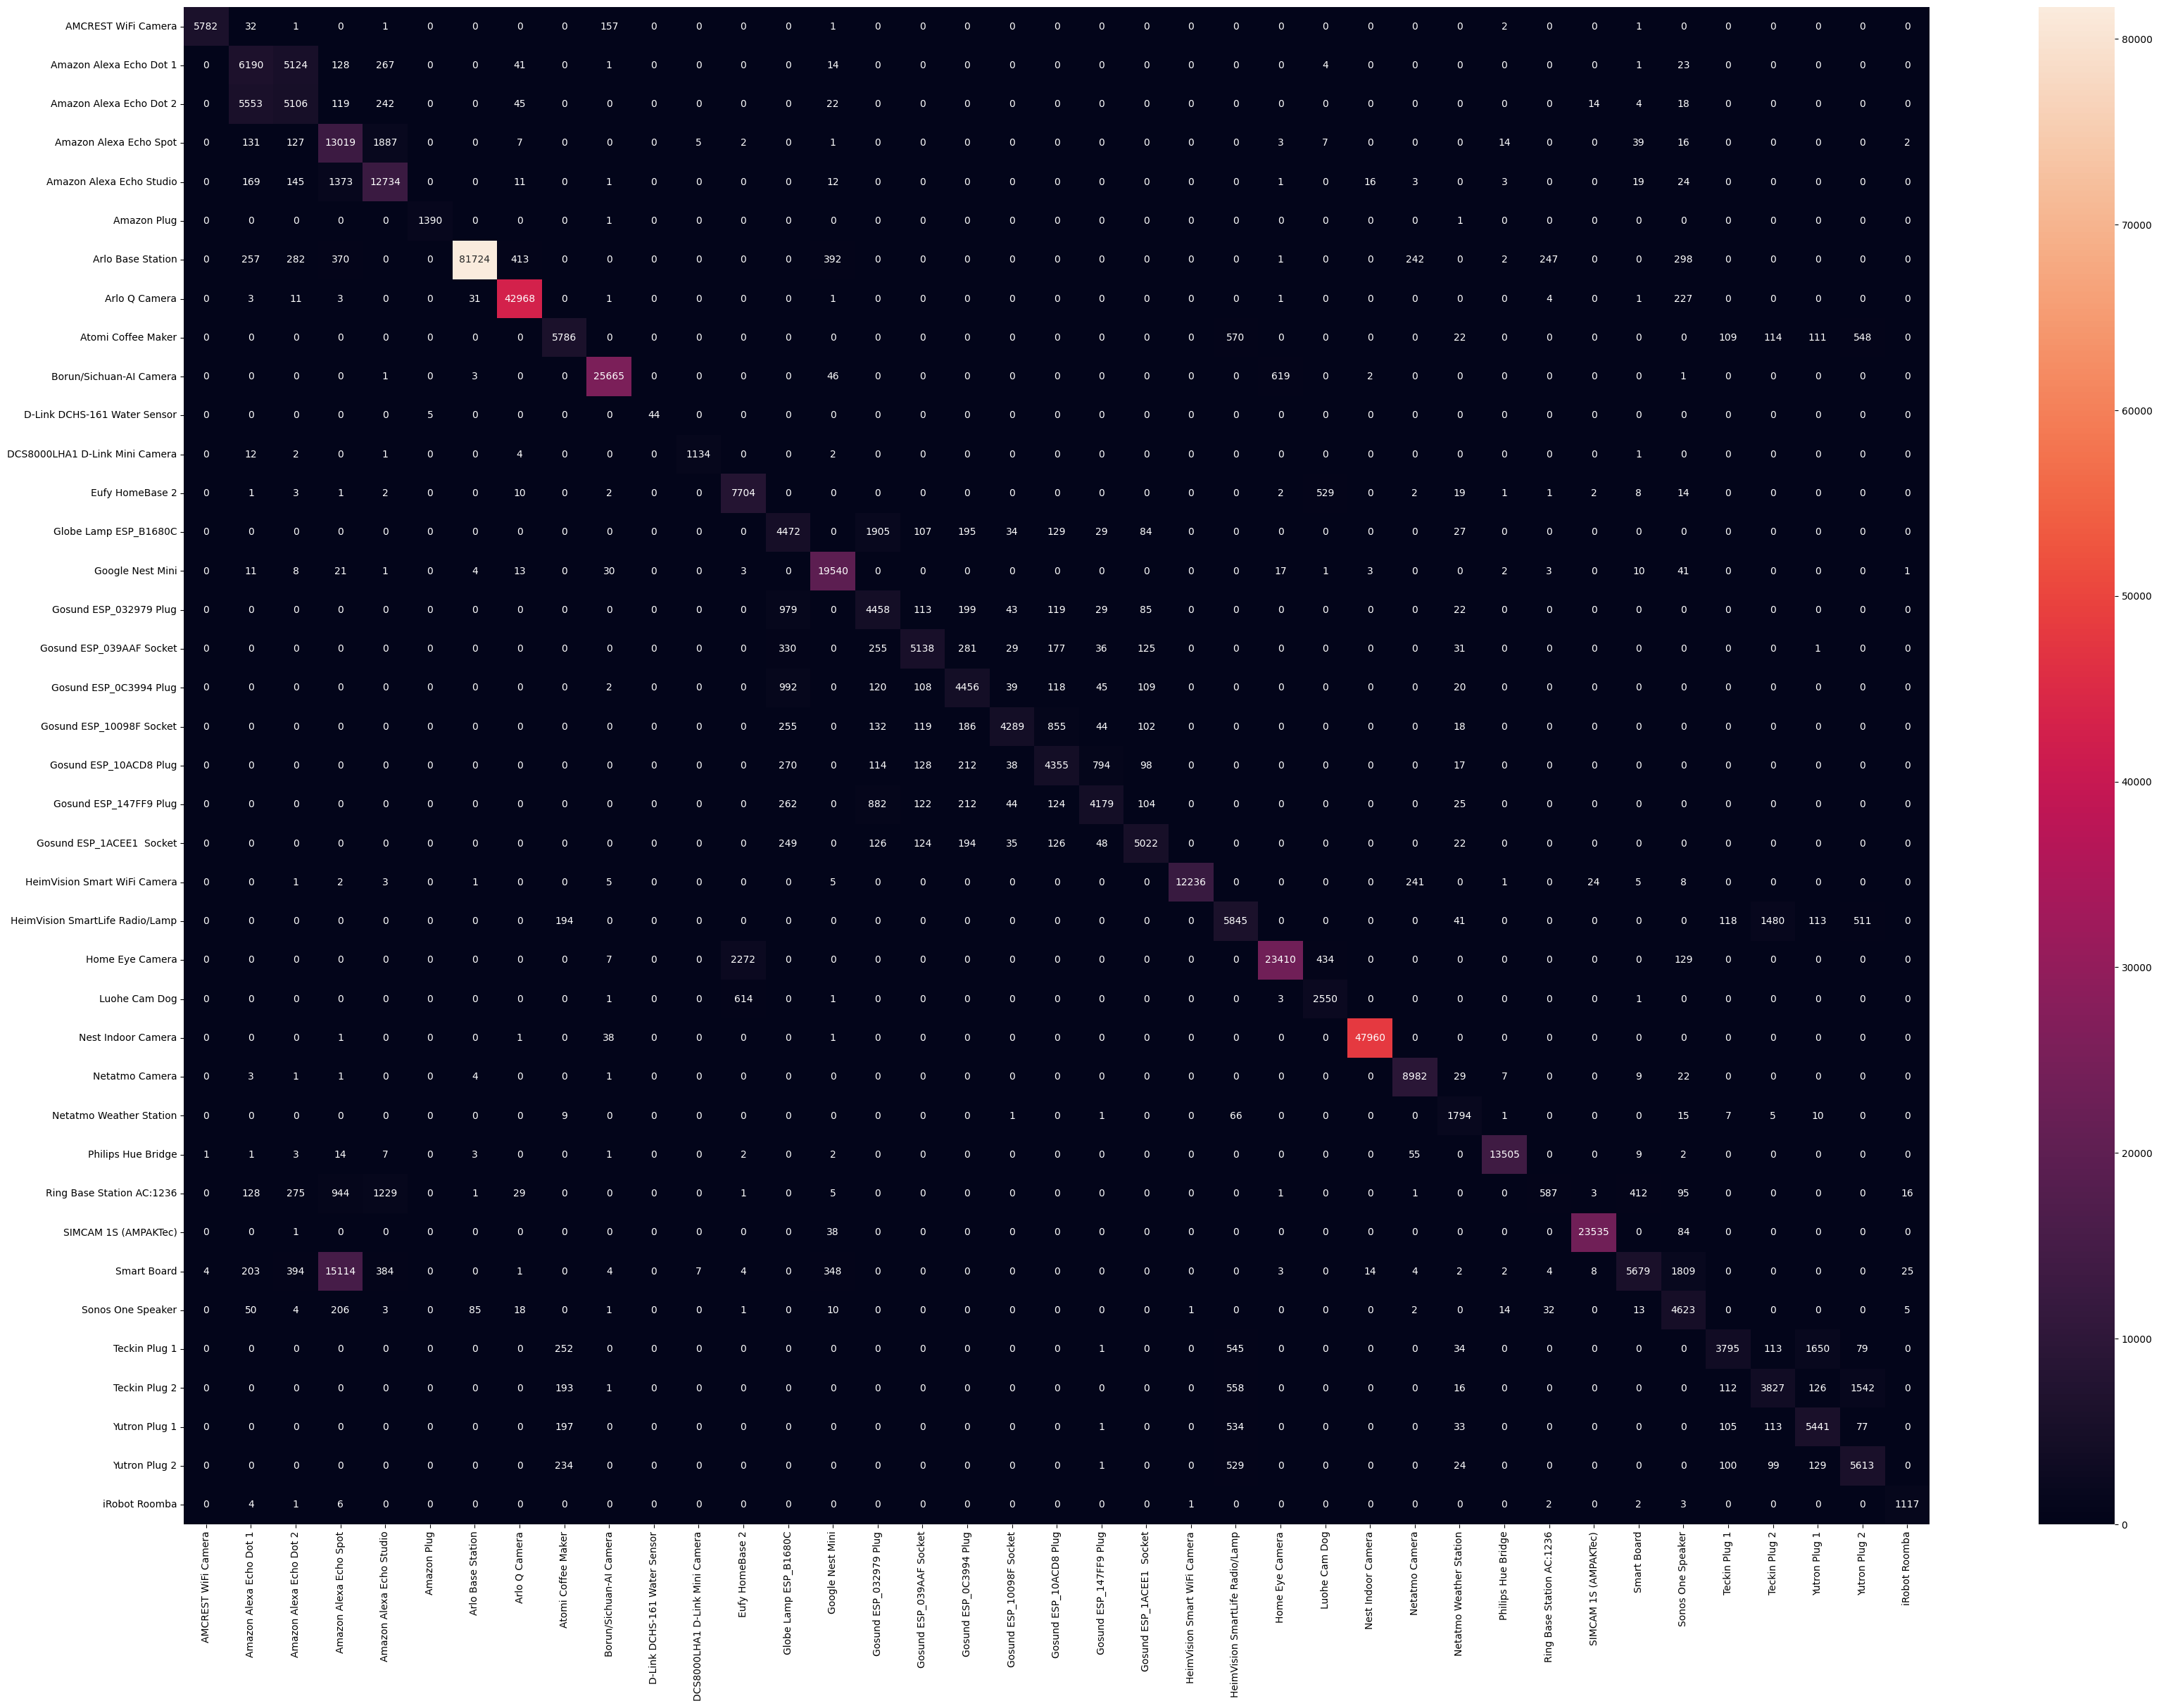

    Dataset         T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/vs_1    0     1  DT    0.877    0.867   0.871  0.867  0.867  0.872      0    3.217     0.361          0
 1  results/vs_1    1     2  DT    0.877    0.866   0.872  0.866  0.867  0.872      0    3.209     0.363          0
 2  results/vs_1    2     3  DT    0.878    0.867   0.872  0.867  0.867  0.873      0    3.377     0.358          0
 3  results/vs_1    3     4  DT    0.877    0.866   0.871  0.866  0.867  0.872      0    3.678     0.376          0
 4  results/vs_1    4     5  DT    0.877    0.866   0.871  0.866  0.867  0.872      0    3.539     0.384          0
 5  results/vs_1    5     6  DT    0.877    0.866   0.87   0.866  0.866  0.872      0    3.272     0.342          0
 6  results/vs_1    6     7  DT    0.878    0.867   0.872  0.867  0.867 

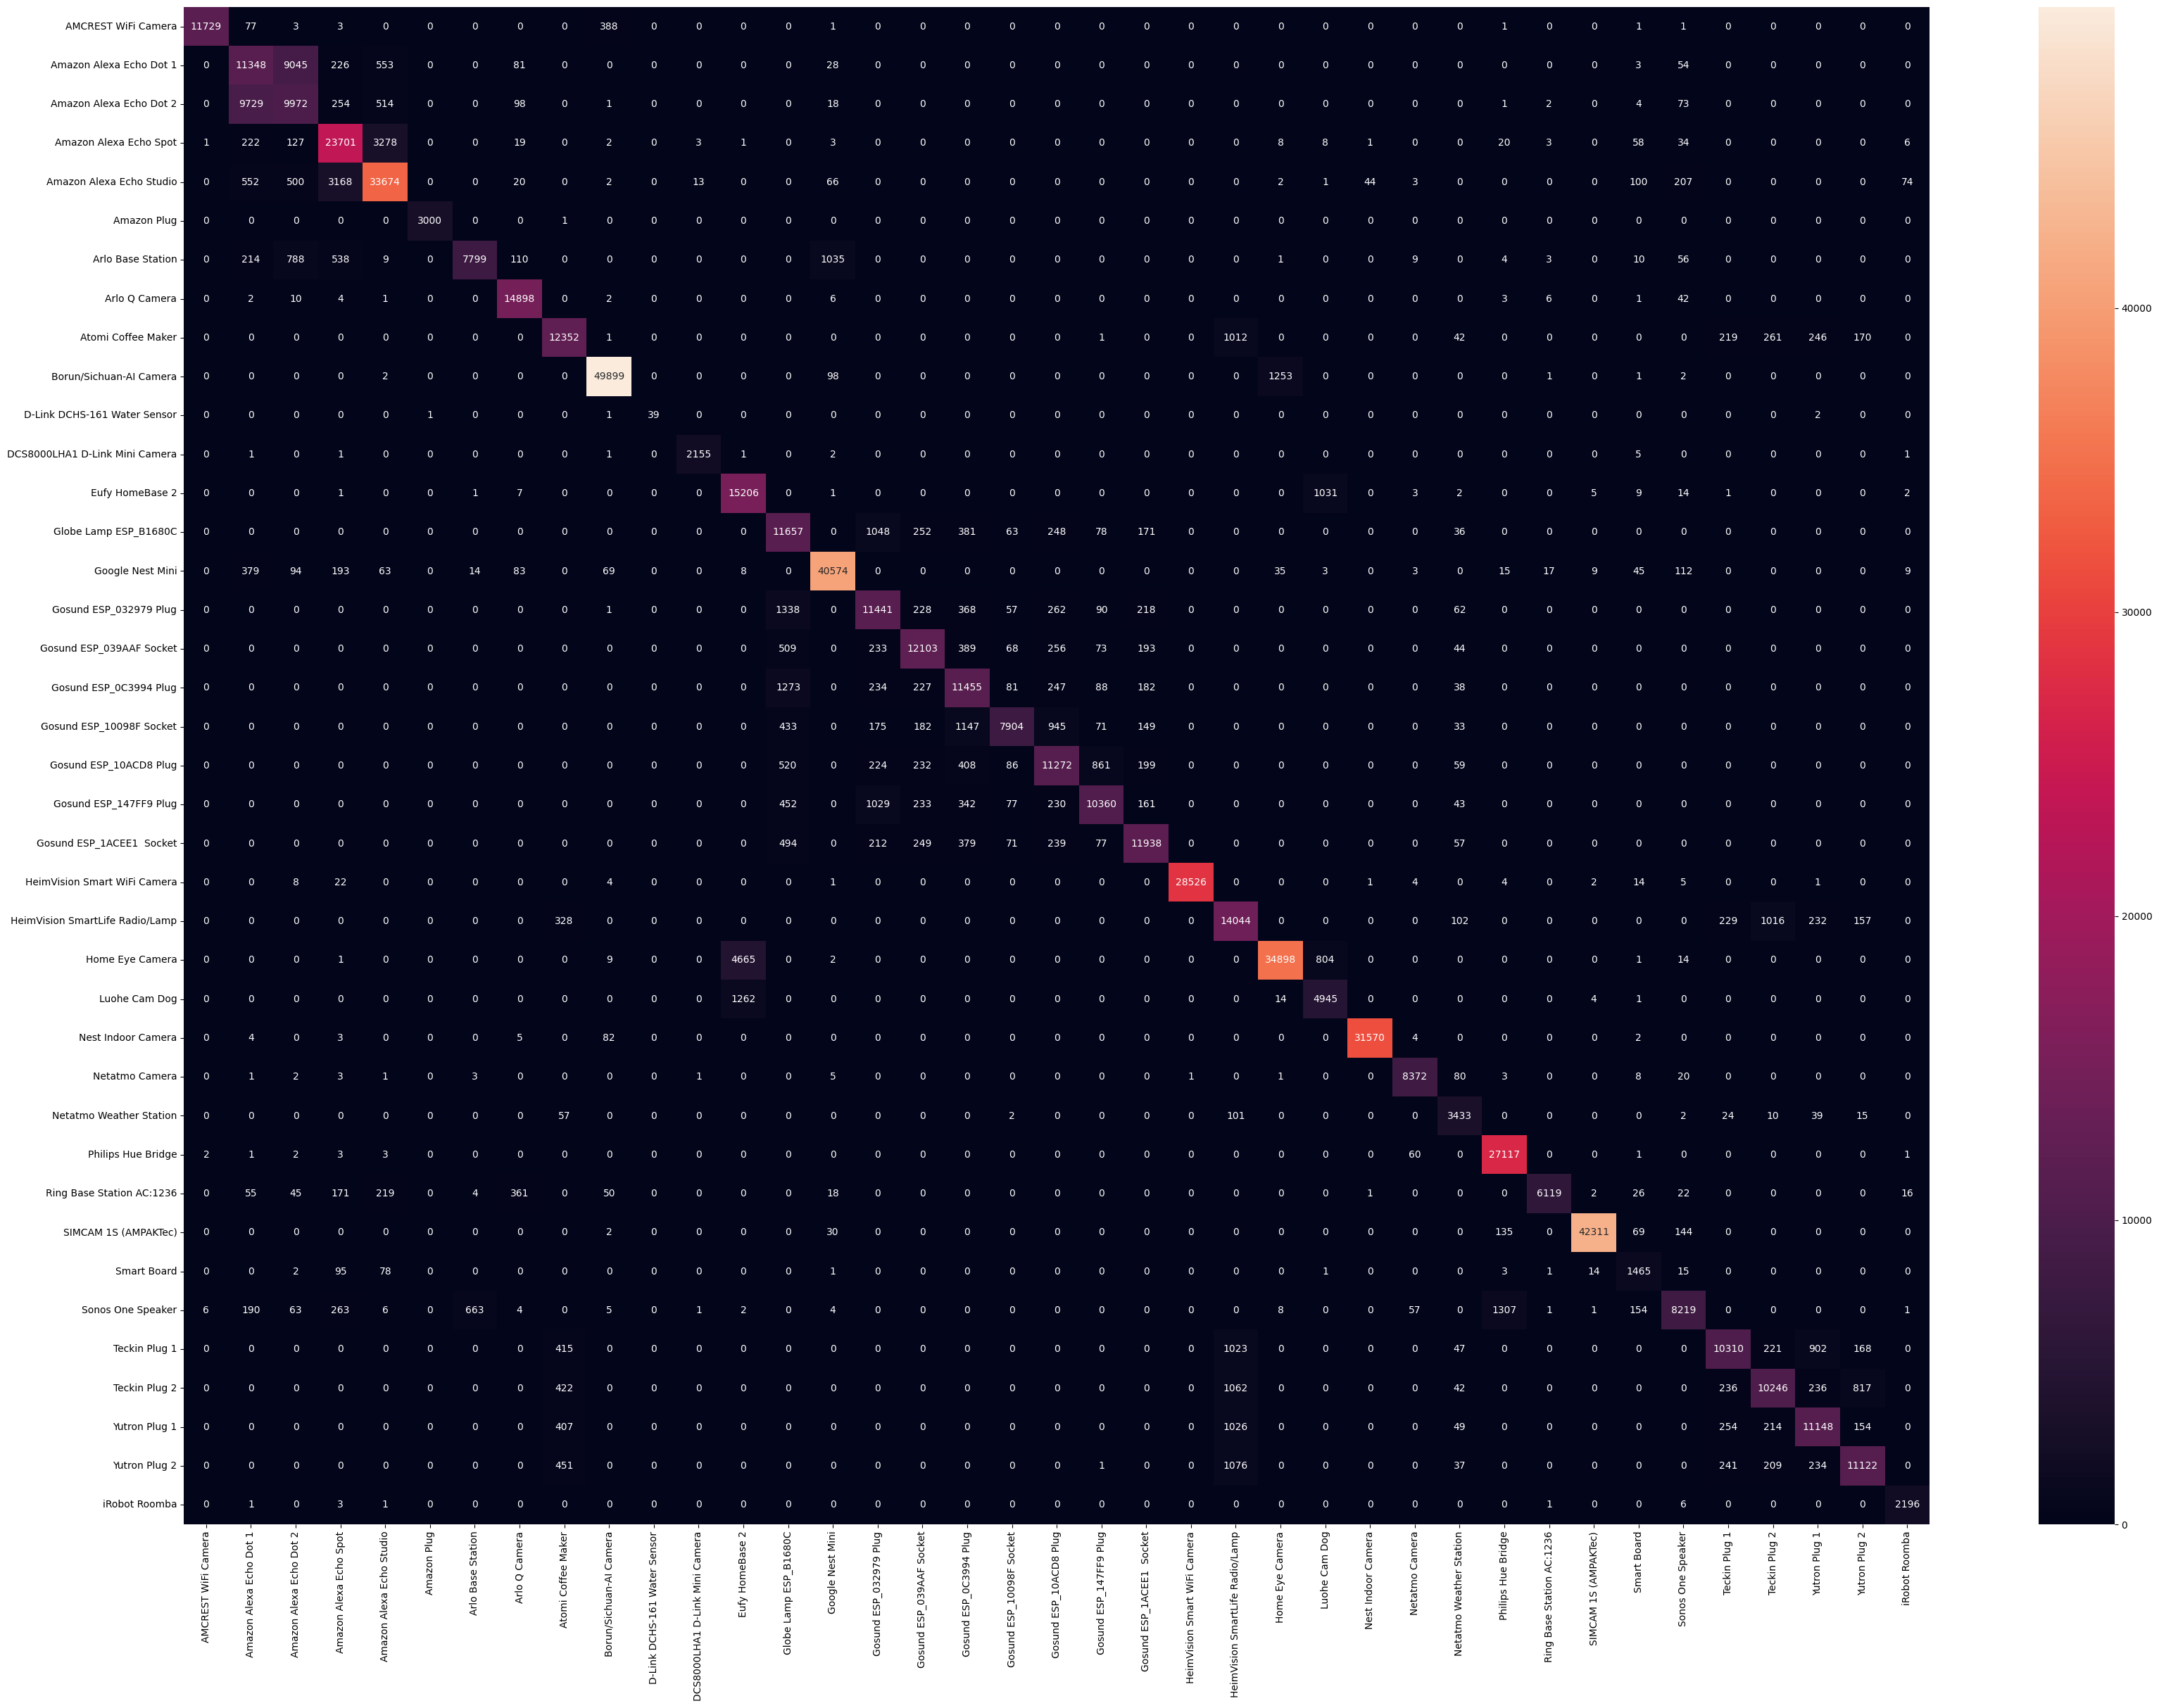

    Dataset         T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/vs_1    0     1  DT    0.796    0.85    0.821  0.85   0.806  0.786      0    3.626     0.285          0
 1  results/vs_1    1     2  DT    0.797    0.849   0.821  0.849  0.807  0.786      0    3.566     0.264          0
 2  results/vs_1    2     3  DT    0.797    0.85    0.819  0.85   0.805  0.786      0    3.801     0.328          0
 3  results/vs_1    3     4  DT    0.797    0.85    0.82   0.85   0.806  0.786      0    3.676     0.277          0
 4  results/vs_1    4     5  DT    0.797    0.85    0.821  0.85   0.807  0.786      0    3.804     0.285          0
 5  results/vs_1    5     6  DT    0.797    0.849   0.821  0.849  0.807  0.786      0    3.799     0.244          0
 6  results/vs_1    6     7  DT    0.796    0.849   0.819  0.849  0.805 

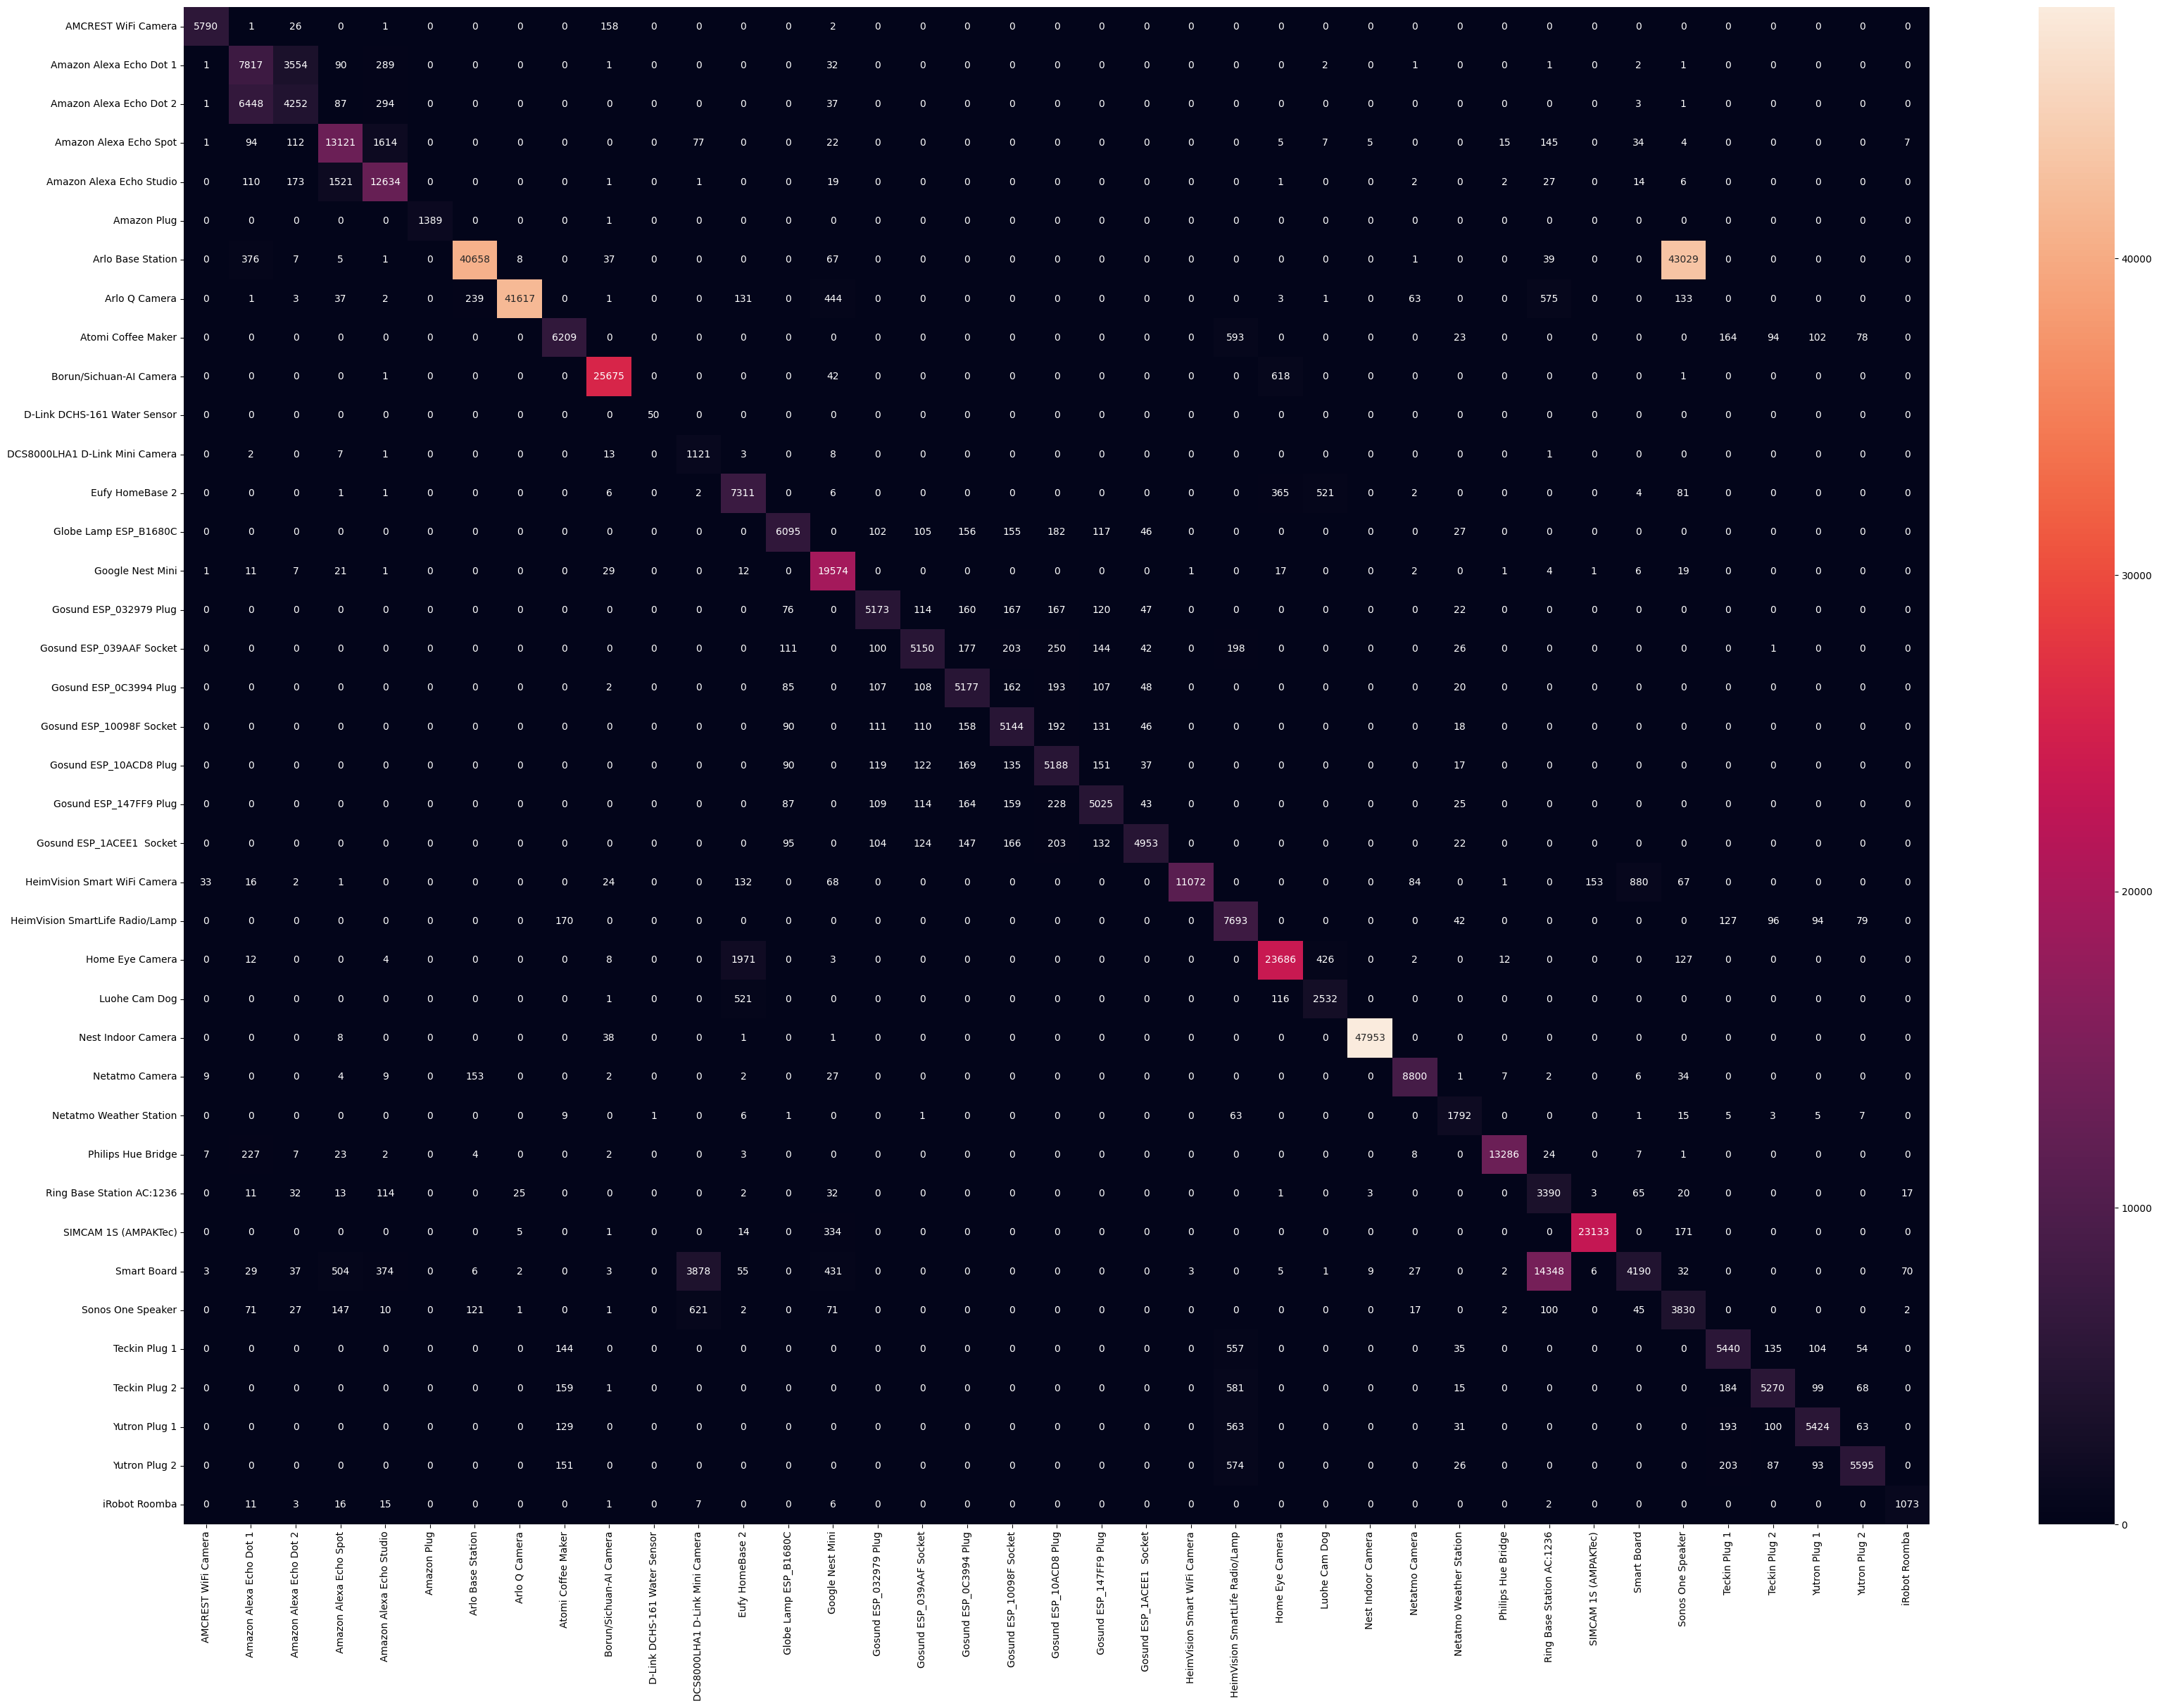

    Dataset         T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/vs_1    0     1  DT    0.742    0.703   0.712  0.703  0.693  0.732      0    3.242     0.367          0
 1  results/vs_1    1     2  DT    0.743    0.703   0.717  0.703  0.696  0.732      0    3.687     0.364          0
 2  results/vs_1    2     3  DT    0.742    0.703   0.716  0.703  0.695  0.732      0    3.683     0.378          0
 3  results/vs_1    3     4  DT    0.742    0.702   0.72   0.702  0.695  0.732      0    3.472     0.351          0
 4  results/vs_1    4     5  DT    0.742    0.702   0.721  0.702  0.695  0.732      0    3.44      0.344          0
 5  results/vs_1    5     6  DT    0.743    0.703   0.722  0.703  0.696  0.732      0    3.538     0.358          0
 6  results/vs_1    6     7  DT    0.743    0.703   0.723  0.703  0.696 

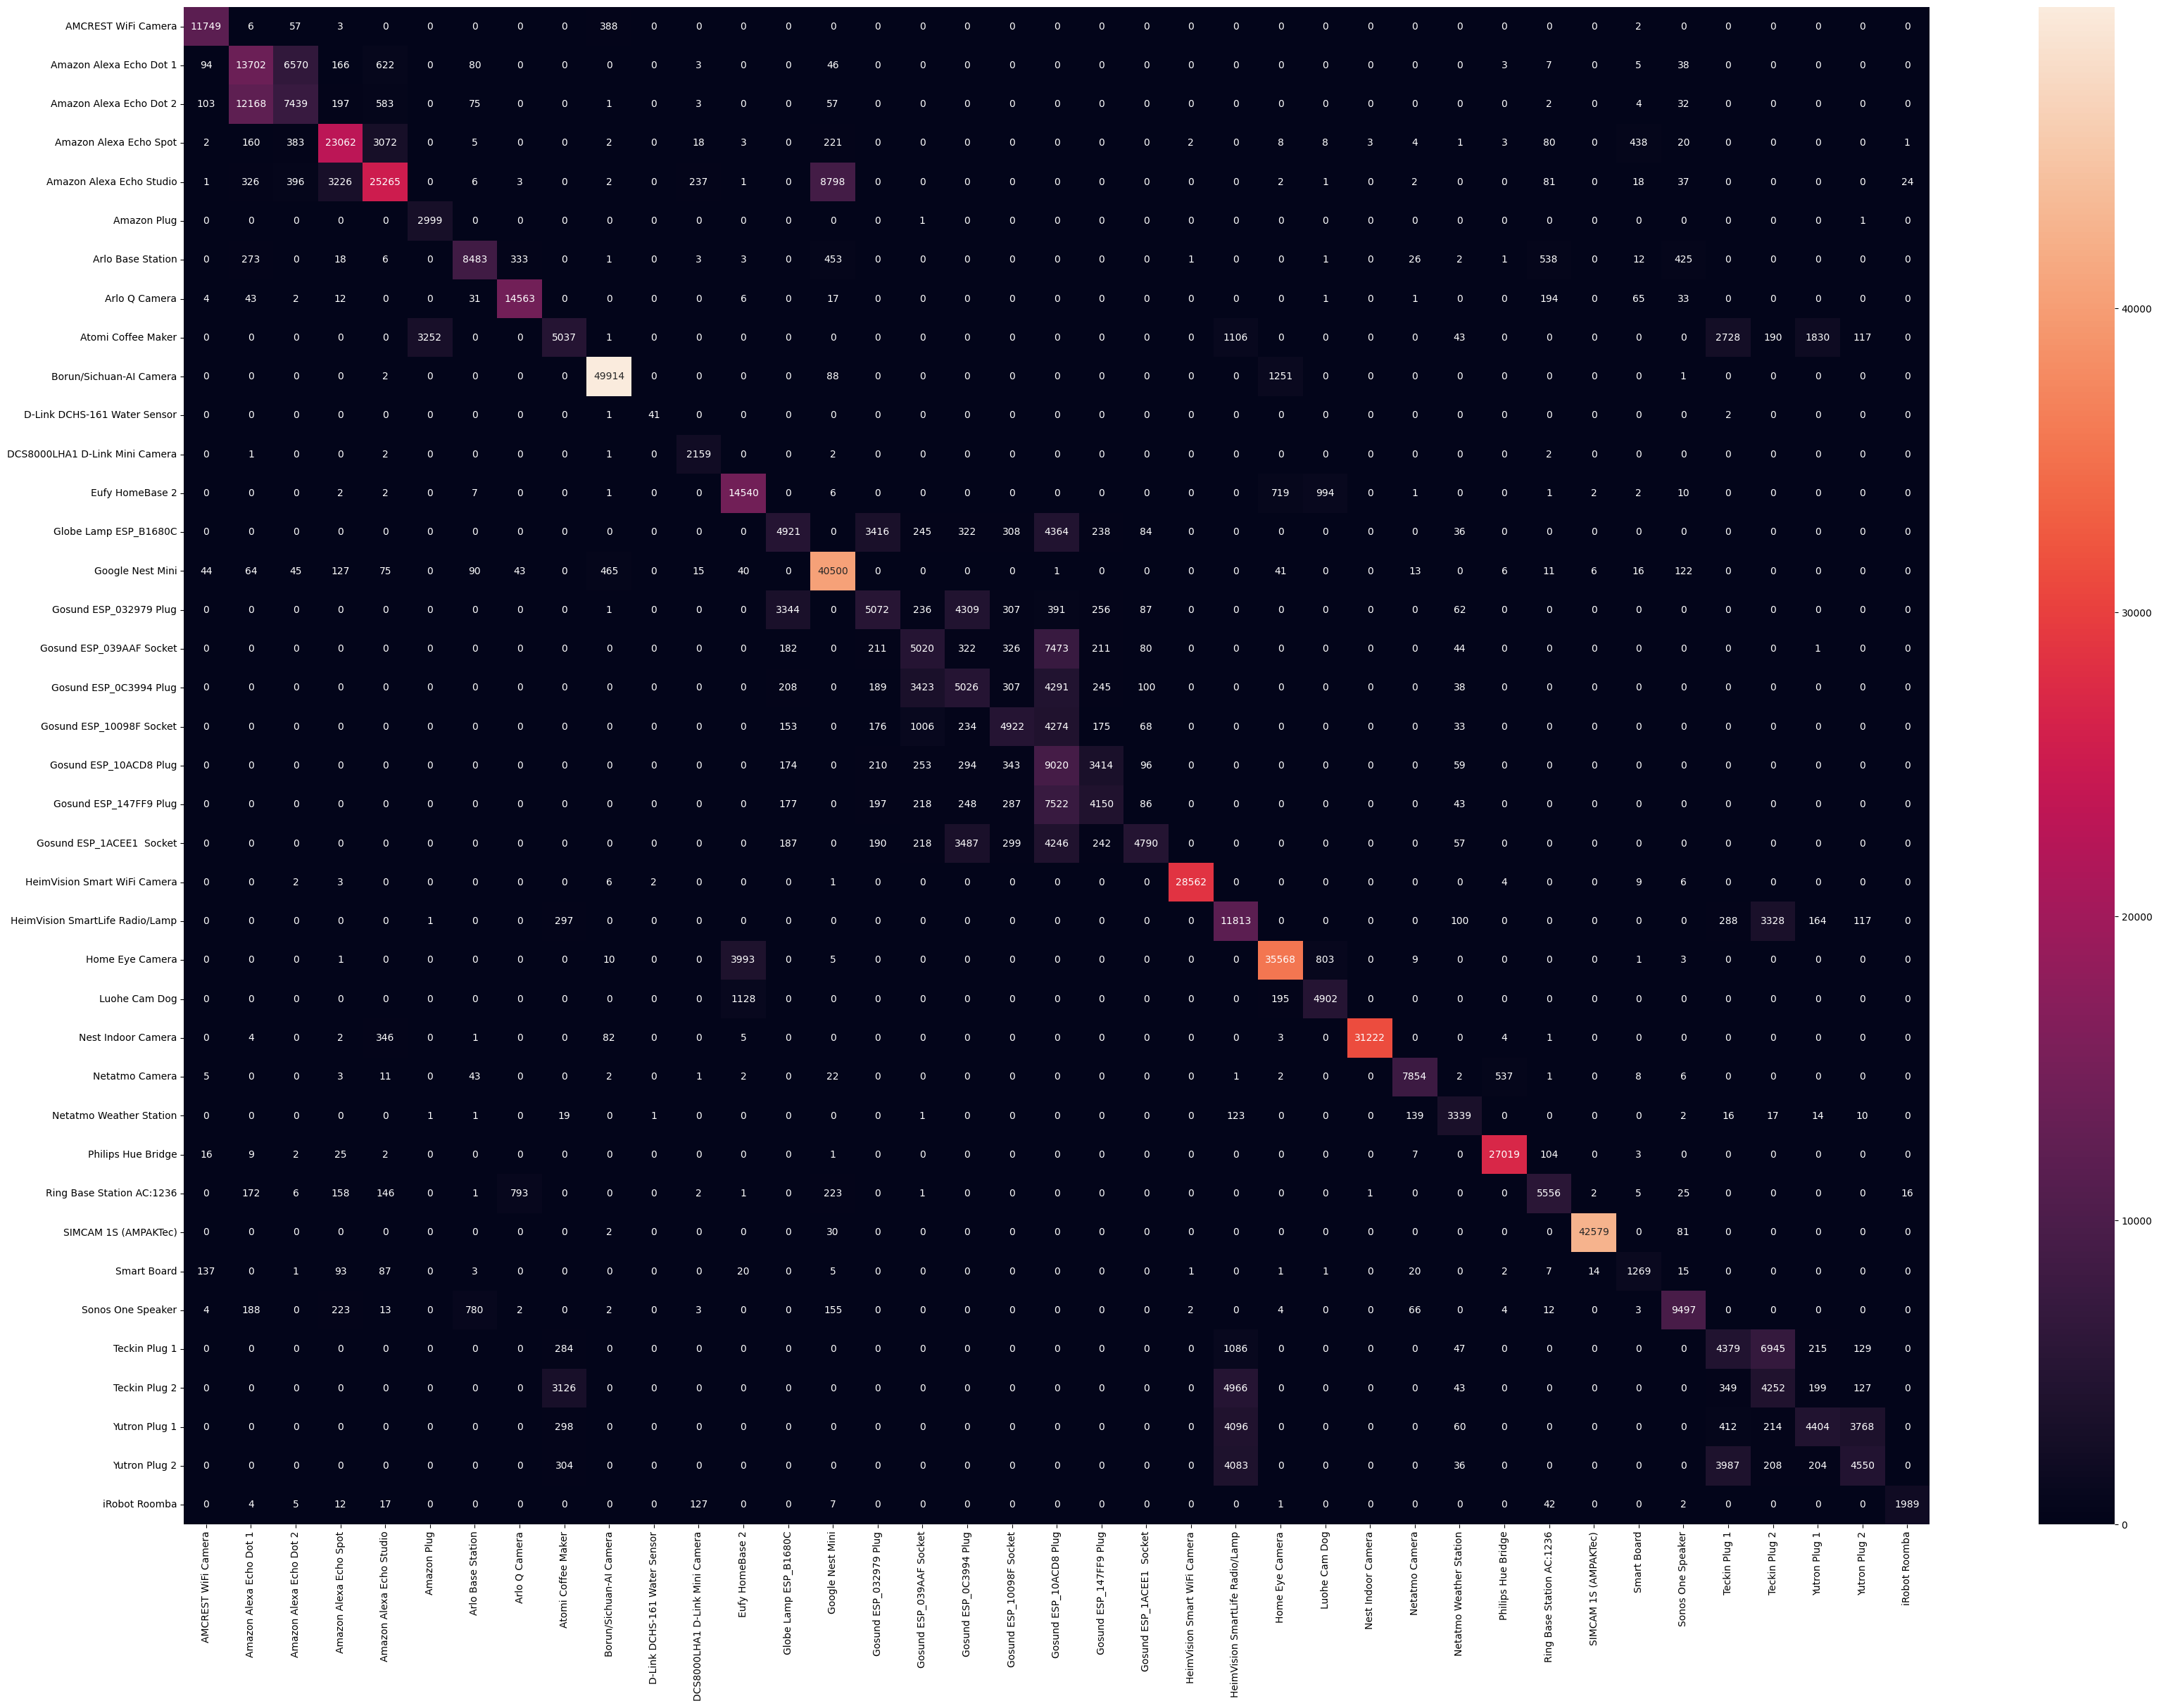

In [11]:
say=0
dataset="./results/vs/"
folder(dataset)
for ii in ["./csvs/ACTIVE_Train.csv","./csvs/IDLE_Train.csv"]:
    for iii in ["./csvs/ACTIVE_Test.csv","./csvs/IDLE_Test.csv"]:
        say+=1
        train=ii
        test=iii
        mixed=False
        step=1
        sayac=1
        output_csv=f"{dataset}/@{ii[7:-4]}@{iii[7:-4]}.csv"
        target_names=target_name(test)
        ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


    Dataset          T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/son_1    0     1  DT    0.861    0.809   0.818  0.809  0.799  0.851      0    3.666     0.285          0
 1  results/son_1    1     2  DT    0.861    0.809   0.818  0.809  0.799  0.851      0    3.718     0.28           0
 2  results/son_1    2     3  DT    0.86     0.808   0.817  0.808  0.798  0.851      0    3.72      0.276          0
 3  results/son_1    3     4  DT    0.861    0.809   0.818  0.809  0.799  0.851      0    3.675     0.285          0
 4  results/son_1    4     5  DT    0.86     0.809   0.817  0.809  0.799  0.851      0    3.726     0.28           0
 5  results/son_1    5     6  DT    0.86     0.809   0.817  0.809  0.799  0.851      0    3.755     0.281          0
 6  results/son_1    6     7  DT    0.861    0.808   0.818  0.80

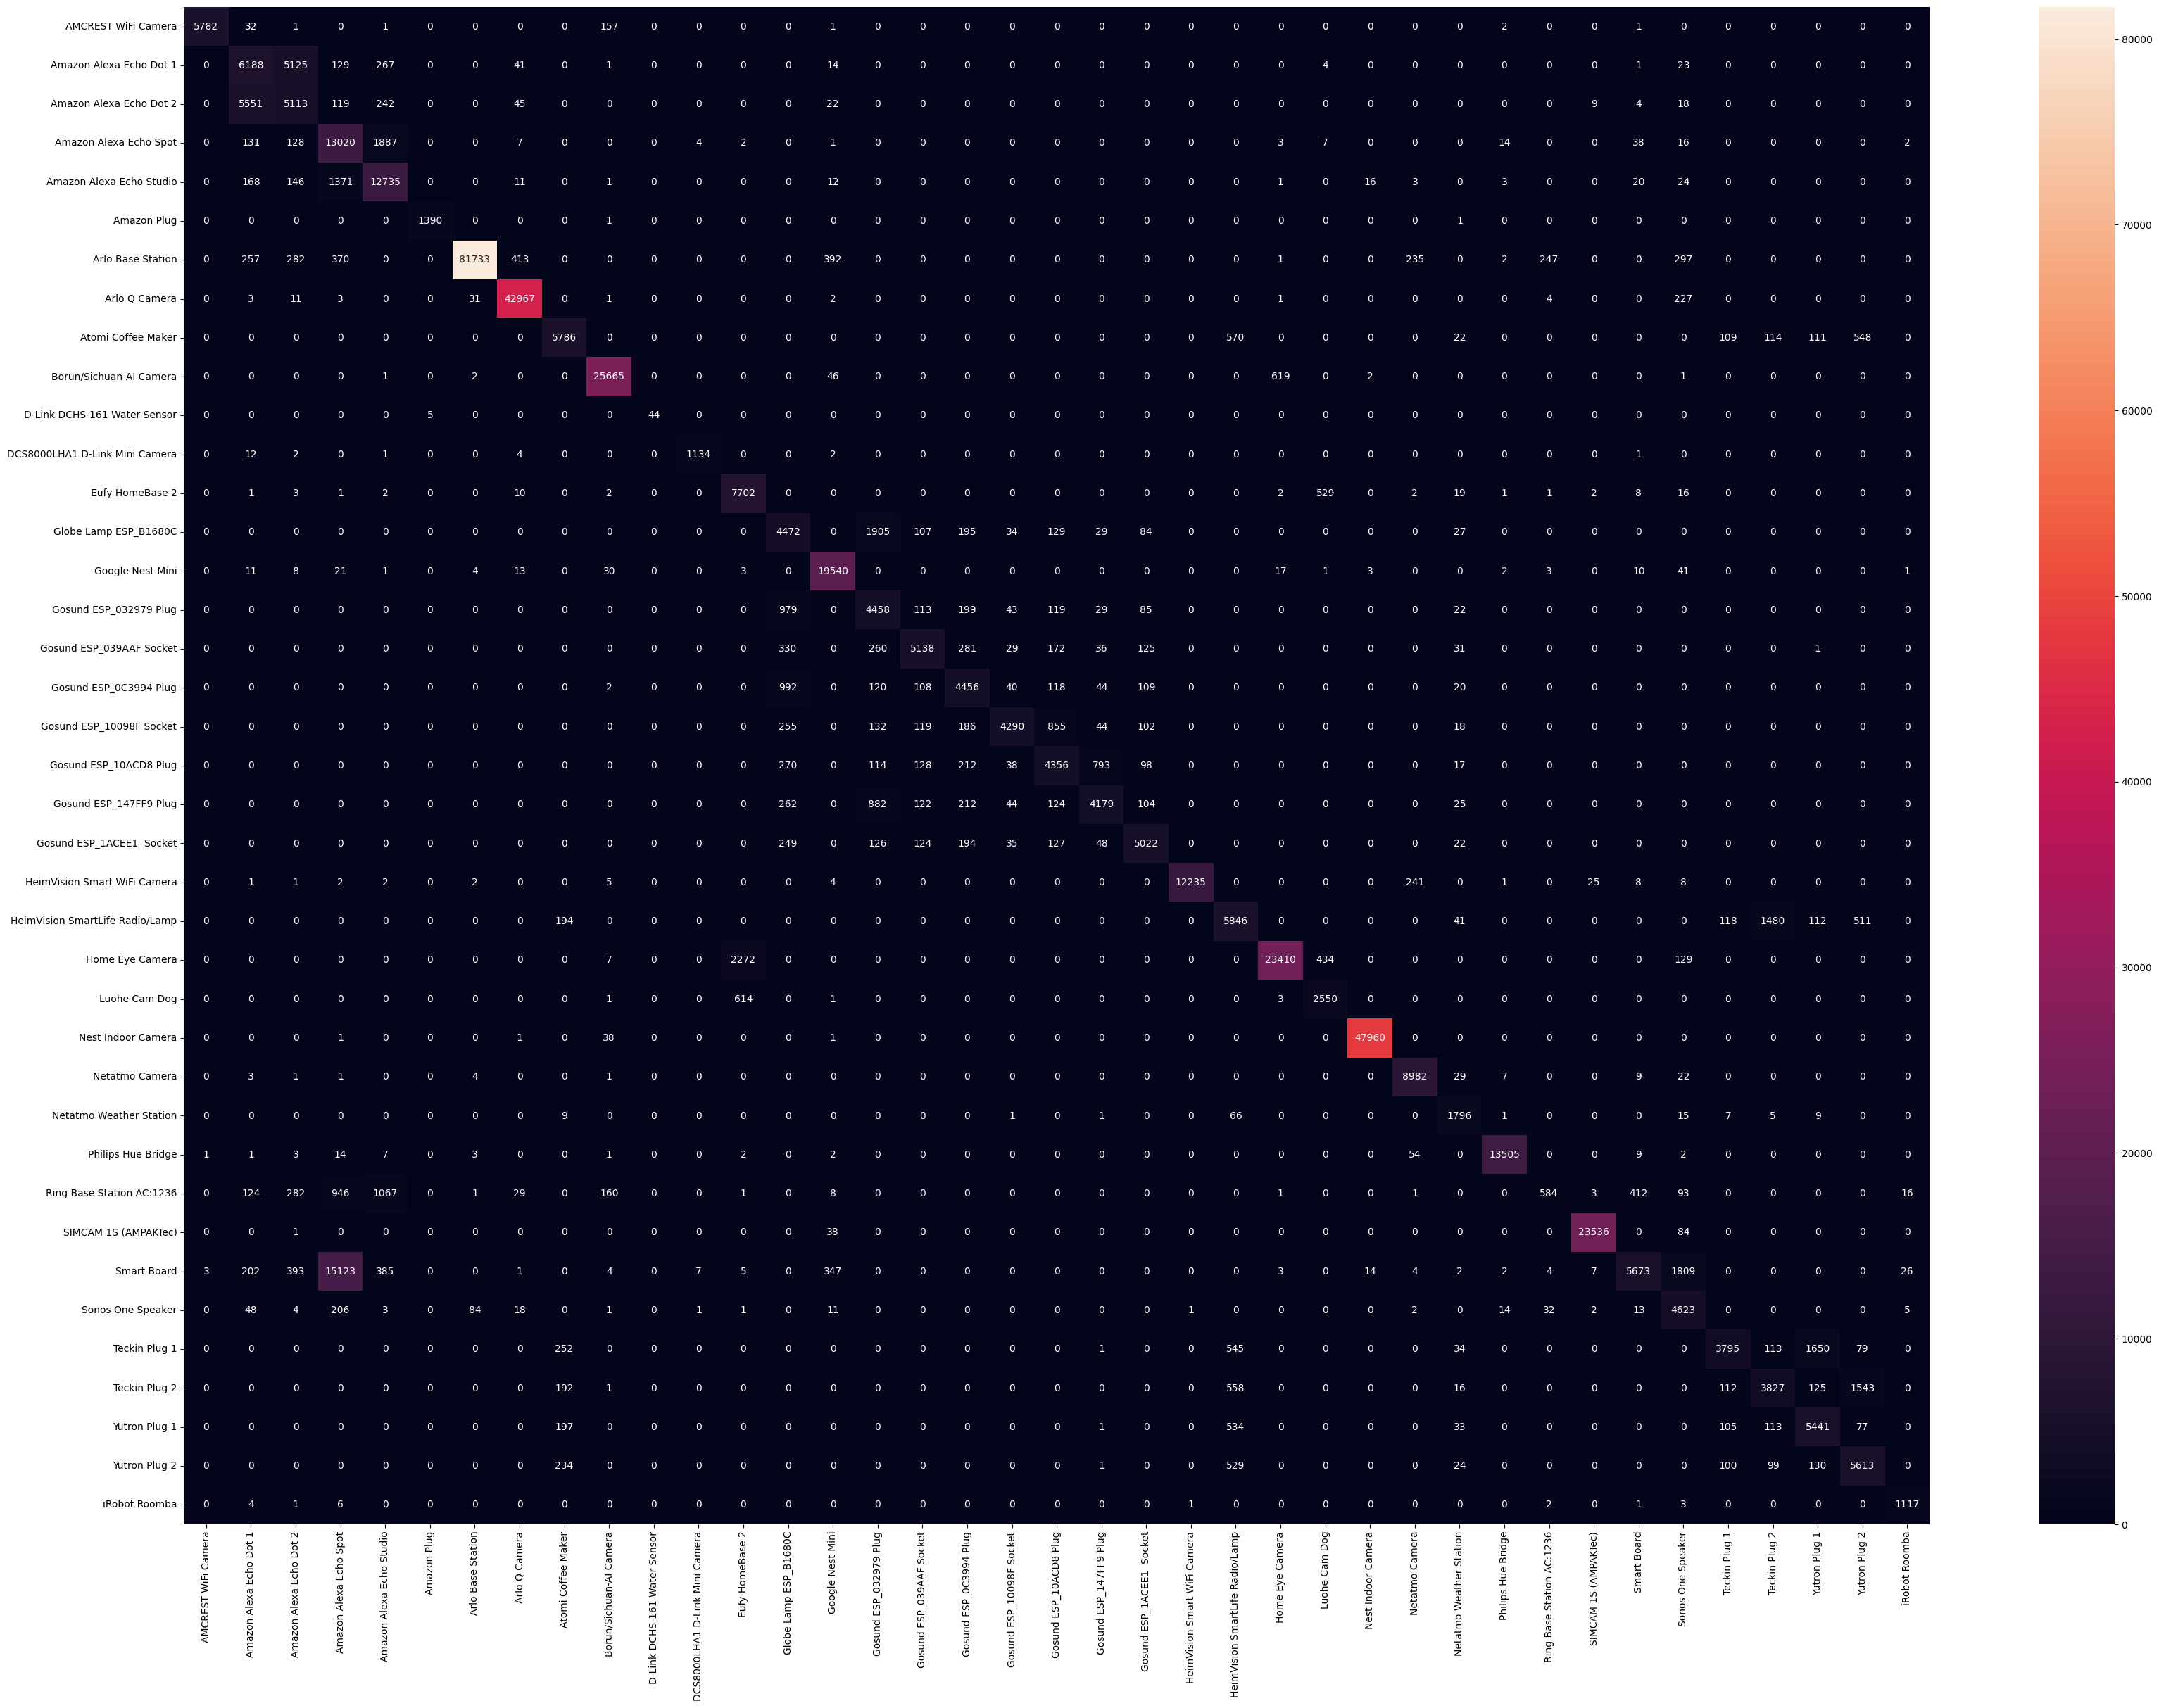

In [12]:
say=0
dataset="./results/son/"
folder(dataset)

say+=1

train="./csvs/ACTIVE_Train.csv"
test="./csvs/ACTIVE_Test.csv"


mixed=False
step=1
sayac=1
output_csv=f"{dataset}/@{train[7:-4]}@{test[7:-4]}.csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   

In [ ]:
say=0
dataset="./results/son/"
folder(dataset)

say+=1

train="./csvs/ACTIVE_Train.csv"
test="./csvs/ACTIVE_Test.csv"


mixed=False
step=1
sayac=1
output_csv=f"{dataset}/@{train[7:-4]}@{test[7:-4]}.csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


In [ ]:
#!shutdown /s /t 360

# Normal Results

In [ ]:
test='test.csv'
train='train.csv'



dataset="./Aalto/False/"
folder(dataset)
mixed=False
step=1
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


# Aggregated Results (Size 13)

In [ ]:
test='test.csv'
train='train.csv'



dataset="./Aalto/False/"
folder(dataset)

mixed=False
step=13
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


# Mixed (Size 13)

In [ ]:
test='test.csv'
train='train.csv'



dataset="./Aalto/False/"
folder(dataset)

mixed=True
step=13
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


In [ ]:
{1111111111011111110111111011111111111111: ['./csvs\\2021_11_02_Active_FE.csv',
  './csvs\\2021_11_02_Idle_FE.csv',
  './csvs\\2021_11_03_Idle_FE.csv',
  './csvs\\2021_11_04_Idle_FE.csv',
  './csvs\\2021_11_05_Active_FE.csv'],
 1111111111011111110111111111111111111111: ['./csvs\\2021_11_03_Active_FE.csv'],
 1111111111011111111111111011111111111111: ['./csvs\\2021_11_08_Active_FE.csv',
  './csvs\\2021_11_08_Idle_FE.csv',
  './csvs\\2021_11_09_Active_FE.csv',
  './csvs\\2021_11_12_Idle_FE.csv',
  './csvs\\2021_11_15_Active_FE.csv',
  './csvs\\2021_11_15_Idle_FE.csv',
  './csvs\\2021_11_16_Active_FE.csv',
  './csvs\\2021_11_17_Active_FE.csv',
  './csvs\\2021_11_18_Active_FE.csv',
  './csvs\\2021_11_18_Idle_FE.csv',
  './csvs\\2021_11_19_Idle_FE.csv',
  './csvs\\2021_11_22_Active_FE.csv',
  './csvs\\2021_11_22_Idle_FE.csv',
  './csvs\\2021_11_23_Active_FE.csv',
  './csvs\\2021_11_25_Active_FE.csv',
  './csvs\\2021_12_06_Active_FE.csv',
  './csvs\\2021_12_08_Active_FE.csv',
  './csvs\\2021_12_23_Active_FE.csv',
  './csvs\\2021_12_25_Active_FE.csv',
  './csvs\\2021_12_28_Active_FE.csv'],
 1111111111011111111101111011111111111111: ['./csvs\\2021_11_10_Active_FE.csv',
  './csvs\\2021_11_10_Idle_FE.csv',
  './csvs\\2021_11_12_Active_FE.csv'],
 1111111111011111111111111011111110111111: ['./csvs\\2021_11_16_Idle_FE.csv',
  './csvs\\2021_11_17_Idle_FE.csv'],
 1111111111011111111111011011111111111111: ['./csvs\\2021_11_19_Active_FE.csv'],
 1111111111111111111111111011111111111111: ['./csvs\\2021_11_24_Active_FE.csv',
  './csvs\\2021_11_24_Idle_FE.csv',
  './csvs\\2021_11_25_Idle_FE.csv',
  './csvs\\2021_12_01_Idle_FE.csv',
  './csvs\\2021_12_02_Idle_FE.csv',
  './csvs\\2021_12_03_Idle_FE.csv',
  './csvs\\2021_12_07_Idle_FE.csv',
  './csvs\\2021_12_08_Idle_FE.csv',
  './csvs\\2021_12_09_Idle_FE.csv',
  './csvs\\2021_12_10_Idle_FE.csv',
  './csvs\\2021_12_13_Idle_FE.csv',
  './csvs\\2021_12_15_Idle_FE.csv',
  './csvs\\2021_12_16_Idle_FE.csv',
  './csvs\\2021_12_20_Idle_FE.csv',
  './csvs\\2021_12_22_Idle_FE.csv',
  './csvs\\2021_12_23_Idle_FE.csv'],
 1111111111011111111111111111111111111111: ['./csvs\\2021_11_26_Active_FE.csv',
  './csvs\\2021_12_07_Active_FE.csv'],
 1111101111111111111111111011111111111111: ['./csvs\\2021_11_26_Idle_FE.csv'],
 1111111111111111111111111011111011111111: ['./csvs\\2021_11_29_Idle_FE.csv'],
 1111111111111110111111111011111111111111: ['./csvs\\2021_11_30_Idle_FE.csv'],
 1111111111011111111111111001111111111111: ['./csvs\\2022_01_03_Active_FE.csv']}